<a href="https://colab.research.google.com/github/HuseinKhorakiwala/Spotify-Music-Data-Analysis-PySpark-Visualization-/blob/main/Spotify_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq

!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xzf spark-3.3.2-bin-hadoop3.tgz -C /content


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
!sed -i '/r2u.stat.illinois.edu/d' /etc/apt/sources.list /etc/apt/sources.list.d/* || true

!apt-get clean
!apt-get update -y


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [ ]:
!apt-get install openjdk-11-jdk-headless -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [2]:
!java -version


java version "21.0.5" 2024-10-15 LTS
Java(TM) SE Runtime Environment (build 21.0.5+9-LTS-239)
Java HotSpot(TM) 64-Bit Server VM (build 21.0.5+9-LTS-239, mixed mode, sharing)


In [10]:
# !wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
# !tar -xzf spark-3.3.2-bin-hadoop3.tgz -C /content/

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"], os.environ["JAVA_HOME"]

('/home/omnissiah/SPARK', '/usr/lib/jvm/java-11-openjdk-amd64')

In [ ]:
!pip install -q pyspark==3.3.2 findspark pandas matplotlib plotly kaggle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.3.2 which is incompatible.


In [9]:
import findspark
findspark.init(os.environ["SPARK_HOME"])

from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .master("local[*]")
         .appName("SpotifyAnalyzer")
         .config("spark.sql.warehouse.dir", "/content/spark-warehouse")  # local "warehouse" as Hive store
         .config("spark.driver.memory", "4g")
         .enableHiveSupport()   # enables create/saveAsTable
         .getOrCreate())

spark.sparkContext.setLogLevel("WARN")
print("Spark started:", spark)


25/10/22 15:53:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
Spark started: <pyspark.sql.session.SparkSession object at 0x7f6dc38107d0>


In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d zaheenhamidani/ultimate-spotify-tracks-db -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db
License(s): unknown
  0% 0.00/15.5M [00:00<?, ?B/s]
100% 15.5M/15.5M [00:00<00:00, 1.15GB/s]


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

schema = StructType([
    StructField("id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("artists", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("popularity", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("danceability", DoubleType(), True),
    StructField("energy", DoubleType(), True),
    StructField("loudness", DoubleType(), True),
    StructField("tempo", DoubleType(), True),
    StructField("valence", DoubleType(), True),
    StructField("genre", StringType(), True),  # if dataset has 'genre'
])

csv_path = "/content/SpotifyFeatures.csv"  # example; check actual filename

df = spark.read.csv(csv_path, header=True, schema=schema, mode="DROPMALFORMED")
df.printSchema()
df.show(5, truncate=100)


root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- genre: string (nullable = true)

+---+----+-------+------------+----------+-----------+------------+------+--------+-----+-------+-----+
| id|name|artists|release_date|popularity|duration_ms|danceability|energy|loudness|tempo|valence|genre|
+---+----+-------+------------+----------+-----------+------------+------+--------+-----+-------+-----+
+---+----+-------+------------+----------+-----------+------------+------+--------+-----+-------+-----+



In [ ]:
from pyspark.sql.functions import col, when, substring, year, to_date

df = df.withColumn("release_date_clean",
                   when(col("release_date").rlike(r'^\d{4}$'), to_date(col("release_date"), "yyyy"))
                   .otherwise(to_date(col("release_date"), "yyyy-MM-dd"))
                  )

from pyspark.sql.functions import year
df = df.withColumn("year", year(col("release_date_clean")))

from pyspark.sql.functions import sum as _sum, isnan
null_counts = df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show(truncate=False)

df = df.dropna(subset=["id","name"])
numeric_cols = ["popularity","duration_ms","danceability","loudness","tempo","valence","energy"]
for c in numeric_cols:
    df = df.withColumn(c, when(col(c).isNull(), 0).otherwise(col(c)))


+----+----+-------+------------+----------+-----------+------------+------+--------+-----+-------+-----+------------------+----+
|id  |name|artists|release_date|popularity|duration_ms|danceability|energy|loudness|tempo|valence|genre|release_date_clean|year|
+----+----+-------+------------+----------+-----------+------------+------+--------+-----+-------+-----+------------------+----+
|null|null|null   |null        |null      |null       |null        |null  |null    |null |null   |null |null              |null|
+----+----+-------+------------+----------+-----------+------------+------+--------+-----+-------+-----+------------------+----+



In [ ]:
!ls -lh /content


total 604M
-rw-r--r--  1 root root   74 Oct 13 03:54 kaggle.json
drwxr-xr-x  1 root root 4.0K Oct  9 13:36 sample_data
drwxr-xr-x 13  501 1000 4.0K Feb 10  2023 spark-3.3.2-bin-hadoop3
-rw-r--r--  1 root root 286M Feb 10  2023 spark-3.3.2-bin-hadoop3.tgz
-rw-r--r--  1 root root 286M Feb 10  2023 spark-3.3.2-bin-hadoop3.tgz.1
-rw-r--r--  1 root root  33M Oct 13 03:54 SpotifyFeatures.csv


In [ ]:
!head -n 5 /content/SpotifyFeatures.csv


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.91,0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.59,137373,0.737,0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816
Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0,C,0.103,-13.879,Minor,0.0362,99.488,5/4,0.368
Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.24,152427,0.326,0,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227


In [ ]:
df = spark.read.csv(csv_path, header=True, inferSchema=True, escape='"', multiLine=True)
df.show(5)
df.printSchema()


+-----+-----------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|genre|      artist_name|          track_name|            track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness| mode|speechiness|  tempo|time_signature|valence|
+-----+-----------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|Movie|   Henri Salvador|C'est beau de fai...|0BRjO6ga9RKCKjfDq...|         0|       0.611|       0.389|      99373|  0.91|             0.0| C#|   0.346|  -1.828|Major|     0.0525|166.969|           4/4|  0.814|
|Movie|Martin & les fées|Perdu d'avance (p...|0BjC1NfoEOOusryeh...|         1|       0.246|        0.59|     137373| 0.737|             0.0| F#|   0.151

In [ ]:
df = spark.read.csv(csv_path, header=True, inferSchema=True, sep=';', escape='"')


In [ ]:
print(df.columns)


['genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence']


In [ ]:
!head -n 3 /content/SpotifyFeatures.csv


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.91,0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.59,137373,0.737,0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spotify Data Analysis") \
    .getOrCreate()

csv_path = "/content/SpotifyFeatures.csv"

df = spark.read.csv(
    csv_path,
    header=True,          # Use first line as column names
    inferSchema=True,     # Automatically detect data types
    sep=",",              # Explicitly specify comma delimiter
    quote='"',            # Handle quoted text
    escape='"',           # Handle escaped quotes
    multiLine=True        # Handle multiline text values (if any)
)

df.show(5)
print("Total rows:", df.count())
df.printSchema()


+-----+-----------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|genre|      artist_name|          track_name|            track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness| mode|speechiness|  tempo|time_signature|valence|
+-----+-----------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|Movie|   Henri Salvador|C'est beau de fai...|0BRjO6ga9RKCKjfDq...|         0|       0.611|       0.389|      99373|  0.91|             0.0| C#|   0.346|  -1.828|Major|     0.0525|166.969|           4/4|  0.814|
|Movie|Martin & les fées|Perdu d'avance (p...|0BjC1NfoEOOusryeh...|         1|       0.246|        0.59|     137373| 0.737|             0.0| F#|   0.151

In [ ]:
from pyspark.sql.functions import col, when, round, avg

print("Total rows:", df.count())
print("Total columns:", len(df.columns))
print("Columns:", df.columns)

for c in df.columns:
    null_count = df.filter((col(c).isNull()) | (col(c) == "")).count()
    if null_count > 0:
        print(f"{c}: {null_count} null values")

df = df.dropna(how="all")

numeric_cols = [field.name for field in df.schema.fields if field.dataType.simpleString() in ["double", "int", "float", "bigint"]]
for col_name in numeric_cols:
    mean_val = df.select(avg(col(col_name))).first()[0]
    if mean_val is not None:
        df = df.na.fill({col_name: mean_val})

df = df.withColumn("genre", when(col("genre").isNull(), "Unknown").otherwise(col("genre")))
df = df.withColumn("artist_name", when(col("artist_name").isNull(), "Unknown").otherwise(col("artist_name")))
df = df.withColumn("track_name", when(col("track_name").isNull(), "Unknown").otherwise(col("track_name")))

df = df.dropDuplicates()

df.createOrReplaceTempView("songs_table")

print("✅ Cleaned data sample:")
df.show(5)
print("✅ Data ready for SQL analysis!")


Total rows: 232725
Total columns: 18
Columns: ['genre', 'artist_name', 'track_name', 'track_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
✅ Cleaned data sample:
+---------+------------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|    genre|       artist_name|          track_name|            track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness| mode|speechiness|  tempo|time_signature|valence|
+---------+------------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|    Movie|            Chorus|               S

In [ ]:
top_artists = spark.sql("""
SELECT artist_name,
       ROUND(AVG(popularity), 2) AS avg_popularity,
       COUNT(track_id) AS total_songs
FROM songs_table
GROUP BY artist_name
ORDER BY avg_popularity DESC
LIMIT 10
""")
top_artists.show(10)


+--------------------+--------------+-----------+
|         artist_name|avg_popularity|total_songs|
+--------------------+--------------+-----------+
|          Pedro Capó|          87.0|          2|
|      Mario Bautista|          85.0|          1|
|         Mau y Ricky|          83.0|          2|
|         Paloma Mami|          82.0|          3|
|               Ninho|          82.0|          1|
|Kris Kross Amsterdam|          82.0|          1|
|       Martin Garrix|         81.86|          7|
|         Sofia Reyes|          81.5|          2|
|              Anitta|          81.0|          3|
|                 NSG|          81.0|          1|
+--------------------+--------------+-----------+



In [ ]:
top_genres = spark.sql("""
SELECT genre,
       ROUND(AVG(popularity), 2) AS avg_popularity,
       COUNT(track_id) AS total_songs
FROM songs_table
GROUP BY genre
ORDER BY avg_popularity DESC
LIMIT 10
""")
top_genres.show(10)


+----------------+--------------+-----------+
|           genre|avg_popularity|total_songs|
+----------------+--------------+-----------+
|             Pop|         66.59|       9386|
|             Rap|         60.53|       9232|
|            Rock|         59.62|       9272|
|         Hip-Hop|         58.42|       9295|
|           Dance|         57.28|       8701|
|           Indie|          54.7|       9543|
|Children’s Music|         54.66|       9353|
|             R&B|         52.31|       8992|
|     Alternative|         50.21|       9263|
|            Folk|         49.94|       9299|
+----------------+--------------+-----------+



In [ ]:
genre_features = spark.sql("""
SELECT genre,
       ROUND(AVG(tempo), 2) AS avg_tempo,
       ROUND(AVG(loudness), 2) AS avg_loudness,
       ROUND(AVG(danceability), 2) AS avg_danceability,
       COUNT(track_id) AS total_songs
FROM songs_table
GROUP BY genre
ORDER BY total_songs DESC
LIMIT 10
""")
genre_features.show(10)


+----------------+---------+------------+----------------+-----------+
|           genre|avg_tempo|avg_loudness|avg_danceability|total_songs|
+----------------+---------+------------+----------------+-----------+
|          Comedy|    98.24|      -11.69|            0.56|       9681|
|      Soundtrack|   104.08|      -19.28|            0.27|       9646|
|           Indie|   119.29|       -7.92|            0.57|       9543|
|            Jazz|   111.78|      -11.21|            0.59|       9441|
|             Pop|   121.18|        -6.5|            0.64|       9386|
|      Electronic|   125.85|       -7.04|            0.62|       9377|
|Children’s Music|   121.93|       -6.53|            0.54|       9353|
|            Folk|   118.75|       -9.87|            0.53|       9299|
|         Hip-Hop|   120.79|       -6.86|            0.72|       9295|
|            Rock|   122.63|       -7.29|            0.54|       9272|
+----------------+---------+------------+----------------+-----------+



In [ ]:
danceable_genres = spark.sql("""
SELECT genre,
       ROUND(AVG(danceability), 3) AS avg_danceability
FROM songs_table
GROUP BY genre
ORDER BY avg_danceability DESC
LIMIT 10
""")
danceable_genres.show(10)


+----------------+----------------+
|           genre|avg_danceability|
+----------------+----------------+
|       Reggaeton|           0.731|
|         Hip-Hop|           0.719|
|          Reggae|           0.699|
|             Rap|           0.697|
|Children's Music|           0.697|
|             R&B|           0.642|
|             Pop|            0.64|
|           Dance|           0.638|
|      Electronic|            0.62|
|            Soul|           0.618|
+----------------+----------------+



In [ ]:
energy_loudness = spark.sql("""
SELECT ROUND(AVG(energy), 3) AS avg_energy,
       ROUND(AVG(loudness), 3) AS avg_loudness
FROM songs_table
""")
energy_loudness.show()


+----------+------------+
|avg_energy|avg_loudness|
+----------+------------+
|     0.571|       -9.57|
+----------+------------+



In [ ]:
from pyspark.sql.functions import mean

duration_stats = df.select(mean(col("duration_ms")).alias("avg_duration")).collect()[0]
print("Average Song Duration (ms):", duration_stats["avg_duration"])


Average Song Duration (ms): 235122.3393060479


In [ ]:
top_keys = spark.sql("""
SELECT key,
       COUNT(track_id) AS total_songs
FROM songs_table
GROUP BY key
ORDER BY total_songs DESC
LIMIT 10
""")
top_keys.show()


+---+-----------+
|key|total_songs|
+---+-----------+
|  C|      27583|
|  G|      26390|
|  D|      24077|
| C#|      23201|
|  A|      22671|
|  F|      20279|
|  B|      17661|
|  E|      17390|
| A#|      15526|
| F#|      15222|
+---+-----------+



In [ ]:
speechiness_genre = spark.sql("""
SELECT genre,
       ROUND(AVG(speechiness), 3) AS avg_speechiness
FROM songs_table
GROUP BY genre
ORDER BY avg_speechiness DESC
LIMIT 10
""")
speechiness_genre.show()


+----------------+---------------+
|           genre|avg_speechiness|
+----------------+---------------+
|          Comedy|          0.854|
|         Hip-Hop|          0.205|
|             Rap|          0.188|
|       Reggaeton|          0.128|
|             R&B|          0.121|
|Children's Music|          0.117|
|          Reggae|          0.116|
|           Movie|          0.109|
|             Pop|          0.108|
|      Electronic|          0.099|
+----------------+---------------+



In [ ]:
valence_energy = spark.sql("""
SELECT ROUND(AVG(valence), 3) AS avg_valence,
       ROUND(AVG(energy), 3) AS avg_energy
FROM songs_table
""")
valence_energy.show()


+-----------+----------+
|avg_valence|avg_energy|
+-----------+----------+
|      0.455|     0.571|
+-----------+----------+



In [ ]:
most_popular_genre = spark.sql("""
SELECT genre,
       ROUND(AVG(popularity), 2) AS avg_popularity
FROM songs_table
GROUP BY genre
ORDER BY avg_popularity DESC
LIMIT 1
""")
most_popular_genre.show()


+-----+--------------+
|genre|avg_popularity|
+-----+--------------+
|  Pop|         66.59|
+-----+--------------+



In [ ]:
longest_tracks = spark.sql("""
SELECT track_name, artist_name, duration_ms
FROM songs_table
ORDER BY duration_ms DESC
LIMIT 10
""")
longest_tracks.show(10)


+--------------------+----------------+-----------+
|          track_name|     artist_name|duration_ms|
+--------------------+----------------+-----------+
|Episodio 15 (Lady...|  La Mesa Reñoña|    5552917|
|           6 : 00 Am|        DJ Luigi|    5488000|
| Lost Lands 2017 Mix|        Excision|    4830606|
|Episodio 14 (Mach...|  La Mesa Reñoña|    4830584|
|Nature Sounds for...| Jamie Llewellyn|    4804015|
|Three Radio Men a...|     Jeff Dunham|    4791725|
|Lo Que No Le Dirí...|Franco Escamilla|    4661991|
|Late Night Tales:...|          Bonobo|    4497994|
|Late Night Tales:...|          Bonobo|    4497994|
|Late Night Tales:...|     Jon Hopkins|    4337529|
+--------------------+----------------+-----------+



In [ ]:
shortest_tracks = spark.sql("""
SELECT track_name, artist_name, duration_ms
FROM songs_table
ORDER BY duration_ms ASC
LIMIT 10
""")
shortest_tracks.show(10)


+--------------------+--------------------+-----------+
|          track_name|         artist_name|duration_ms|
+--------------------+--------------------+-----------+
|          Pat-a-cake|           Neva Eder|      15387|
|Rinaldo, HWV 7a, ...|George Frideric H...|      15509|
|St. John Passion,...|Johann Sebastian ...|      16316|
|S McGregor (inter...|             Solange|      16640|
|S McGregor (inter...|             Solange|      16640|
|S McGregor (inter...|             Solange|      16640|
|St. John Passion,...|Johann Sebastian ...|      16748|
|Narration / Spoke...|Kimbo Children's ...|      16760|
|Who's Got a Birth...|       Toddler Tunes|      17000|
|"Now I'll Take a ...|      Audra McDonald|      17213|
+--------------------+--------------------+-----------+



In [ ]:
most_tracks_genre = spark.sql("""
SELECT genre, COUNT(track_id) AS num_tracks
FROM songs_table
GROUP BY genre
ORDER BY num_tracks DESC
LIMIT 10
""")
most_tracks_genre.show()


+----------------+----------+
|           genre|num_tracks|
+----------------+----------+
|          Comedy|      9681|
|      Soundtrack|      9646|
|           Indie|      9543|
|            Jazz|      9441|
|             Pop|      9386|
|      Electronic|      9377|
|Children’s Music|      9353|
|            Folk|      9299|
|         Hip-Hop|      9295|
|            Rock|      9272|
+----------------+----------+



In [ ]:
top_artists_count = spark.sql("""
SELECT artist_name, COUNT(track_id) AS num_tracks
FROM songs_table
GROUP BY artist_name
ORDER BY num_tracks DESC
LIMIT 10
""")
top_artists_count.show()


+--------------------+----------+
|         artist_name|num_tracks|
+--------------------+----------+
|      Giuseppe Verdi|      1394|
|     Giacomo Puccini|      1137|
|Kimbo Children's ...|       971|
|       Nobuo Uematsu|       825|
|      Richard Wagner|       804|
|Wolfgang Amadeus ...|       800|
|        Randy Newman|       757|
|       Georges Bizet|       701|
|         Juice Music|       684|
|Johann Sebastian ...|       632|
+--------------------+----------+



In [ ]:
avg_loudness_genre = spark.sql("""
SELECT genre, ROUND(AVG(loudness), 2) AS avg_loudness
FROM songs_table
GROUP BY genre
ORDER BY avg_loudness DESC
LIMIT 10
""")
avg_loudness_genre.show()


+----------------+------------+
|           genre|avg_loudness|
+----------------+------------+
|       Reggaeton|       -5.88|
|           Dance|       -6.05|
|             Ska|       -6.17|
|             Pop|        -6.5|
|Children’s Music|       -6.53|
|     Alternative|       -6.54|
|             Rap|       -6.67|
|         Hip-Hop|       -6.86|
|      Electronic|       -7.04|
|            Rock|       -7.29|
+----------------+------------+



In [ ]:
energy_dance = spark.sql("""
SELECT genre,
       ROUND(AVG(energy), 3) AS avg_energy,
       ROUND(AVG(danceability), 3) AS avg_danceability
FROM songs_table
GROUP BY genre
ORDER BY avg_energy DESC
LIMIT 10
""")
energy_dance.show()


+----------------+----------+----------------+
|           genre|avg_energy|avg_danceability|
+----------------+----------+----------------+
|             Ska|     0.816|           0.527|
|       Reggaeton|     0.749|           0.731|
|      Electronic|     0.739|            0.62|
|     Alternative|     0.712|           0.542|
|Children’s Music|     0.707|           0.542|
|           Dance|     0.698|           0.638|
|            Rock|     0.684|           0.538|
|          Comedy|     0.676|           0.559|
|           Anime|     0.665|           0.472|
|             Rap|     0.651|           0.697|
+----------------+----------+----------------+



In [ ]:
happy_tracks = spark.sql("""
SELECT track_name, artist_name, valence
FROM songs_table
WHERE valence >= 0.9
ORDER BY valence DESC
LIMIT 10
""")
happy_tracks.show()


+--------------------+--------------------+-------+
|          track_name|         artist_name|valence|
+--------------------+--------------------+-------+
|   Irish Washerwoman|     Charlton Heston|    1.0|
|There Was A Crook...|   The Hit Crew Kids|    1.0|
|     SNAKE MAN STAGE|   Capcom Sound Team|    1.0|
|Goosey Goosey Gan...|Nursery Rhymes an...|    1.0|
|      Old Mac Donald|      Preschool Kids|    1.0|
|Pat a Cake for Be...|Nursery Rhymes an...|    1.0|
|     The Crooked Man|      Preschool Kids|  0.999|
|     The Crooked Man|Nursery Rhymes an...|  0.998|
|        Jingle Bells|      Preschool Kids|  0.996|
|       Edward's Harp|       Nobuo Uematsu|  0.995|
+--------------------+--------------------+-------+



In [ ]:
high_speechiness = spark.sql("""
SELECT track_name, artist_name, speechiness
FROM songs_table
WHERE speechiness >= 0.66
ORDER BY speechiness DESC
LIMIT 10
""")
high_speechiness.show()


+--------------------+---------------+-----------+
|          track_name|    artist_name|speechiness|
+--------------------+---------------+-----------+
|Kid Rock in the News|   Brian Posehn|      0.967|
|How to Get a Job ...|    Jeff Dunham|      0.965|
|The Possibility o...|    Jeff Dunham|      0.965|
|            Athletes|  Alonzo Bodden|      0.965|
|Star Wars Jokes /...|   Brian Posehn|      0.965|
|        turd whistle|    Tenacious D|      0.965|
|         Who to Hate|  Alonzo Bodden|      0.965|
|Surfing Lesson - ...|   Bill Engvall|      0.965|
|Why Would You Tel...|Hannibal Buress|      0.965|
|           Picked On|   Brian Posehn|      0.965|
+--------------------+---------------+-----------+



In [ ]:
tempo_genre = spark.sql("""
SELECT genre,
       ROUND(AVG(tempo), 2) AS avg_tempo,
       ROUND(MIN(tempo), 2) AS min_tempo,
       ROUND(MAX(tempo), 2) AS max_tempo
FROM songs_table
GROUP BY genre
ORDER BY avg_tempo DESC
LIMIT 10
""")
tempo_genre.show()


+----------------+---------+---------+---------+
|           genre|avg_tempo|min_tempo|max_tempo|
+----------------+---------+---------+---------+
|             Ska|   129.43|    53.07|   221.58|
|           Anime|   126.63|    32.08|   220.28|
|      Electronic|   125.85|    35.55|   220.17|
|         Country|   123.41|    48.72|   217.54|
|            Rock|   122.63|    34.72|   219.33|
|     Alternative|   122.53|    44.19|   213.79|
|Children’s Music|   121.93|    46.69|   213.79|
|             Pop|   121.18|     39.5|   213.99|
|           Blues|   121.14|     35.2|    242.9|
|Children's Music|   121.13|    33.79|   220.12|
+----------------+---------+---------+---------+



In [ ]:
extreme_energy = spark.sql("""
SELECT track_name, artist_name, energy
FROM songs_table
ORDER BY energy DESC
LIMIT 10
""")
extreme_energy.show()


+--------------------+--------------------+------+
|          track_name|         artist_name|energy|
+--------------------+--------------------+------+
|            No Limit|         2 Unlimited| 0.999|
|               ObZen|           Meshuggah| 0.999|
|Undertaker, Under...|     Swingin' Utters| 0.999|
|                Toby|Against All Autho...| 0.999|
|  Miku No Shoushitsu|       cosMo@bousouP| 0.999|
|              Wicked|         Bear Grillz| 0.999|
|Invisible Government|The Suicide Machines| 0.999|
|          The Change|The Suicide Machines| 0.999|
|      Caramelldansen|            Caramell| 0.999|
|           War Story|      Choking Victim| 0.999|
+--------------------+--------------------+------+



In [ ]:


# Top 10 most popular artists
top_artists_pd = top_artists.toPandas()

# Top 10 genres by average popularity
top_genres_pd = top_genres.toPandas()

# Average tempo, loudness, danceability per genre
genre_features_pd = genre_features.toPandas()

# Most danceable genres
danceable_genres_pd = danceable_genres.toPandas()

# Top happy tracks (valence >= 0.9)
happy_tracks_pd = happy_tracks.toPandas()

# Tracks with extreme energy
extreme_energy_pd = extreme_energy.toPandas()

# Tempo statistics per genre (avg, min, max)
tempo_genre_pd = tempo_genre.toPandas()

# Tracks with high speechiness (rap/spoken word)
high_speechiness_pd = high_speechiness.toPandas()

# Top 10 longest tracks
longest_tracks_pd = longest_tracks.toPandas()

# Top 10 shortest tracks
shortest_tracks_pd = shortest_tracks.toPandas()

# Artists with most tracks
top_artists_count_pd = top_artists_count.toPandas()

# Average loudness per genre
avg_loudness_genre_pd = avg_loudness_genre.toPandas()

# Energy vs Danceability per genre
energy_dance_pd = energy_dance.toPandas()

# Most common keys
top_keys_pd = top_keys.toPandas()

# Speechiness per genre
speechiness_genre_pd = speechiness_genre.toPandas()

# Valence vs energy
valence_energy_pd = valence_energy.toPandas()

# Most popular genre overall
most_popular_genre_pd = most_popular_genre.toPandas()


In [ ]:
!pip install streamlit
!pip install plotly


In [ ]:

top_artists.toPandas().to_csv("/content/top_artists.csv", index=False)
top_genres.toPandas().to_csv("/content/top_genres.csv", index=False)
genre_features.toPandas().to_csv("/content/genre_features.csv", index=False)
danceable_genres.toPandas().to_csv("/content/danceable_genres.csv", index=False)
happy_tracks.toPandas().to_csv("/content/happy_tracks.csv", index=False)
extreme_energy.toPandas().to_csv("/content/extreme_energy.csv", index=False)
tempo_genre.toPandas().to_csv("/content/tempo_genre.csv", index=False)
high_speechiness.toPandas().to_csv("/content/high_speechiness.csv", index=False)
longest_tracks.toPandas().to_csv("/content/longest_tracks.csv", index=False)
shortest_tracks.toPandas().to_csv("/content/shortest_tracks.csv", index=False)
top_artists_count.toPandas().to_csv("/content/top_artists_count.csv", index=False)
avg_loudness_genre.toPandas().to_csv("/content/avg_loudness_genre.csv", index=False)
energy_dance.toPandas().to_csv("/content/energy_dance.csv", index=False)
top_keys.toPandas().to_csv("/content/top_keys.csv", index=False)
speechiness_genre.toPandas().to_csv("/content/speechiness_genre.csv", index=False)
valence_energy.toPandas().to_csv("/content/valence_energy.csv", index=False)
most_popular_genre.toPandas().to_csv("/content/most_popular_genre.csv", index=False)



/tmp/ipython-input-340764407.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




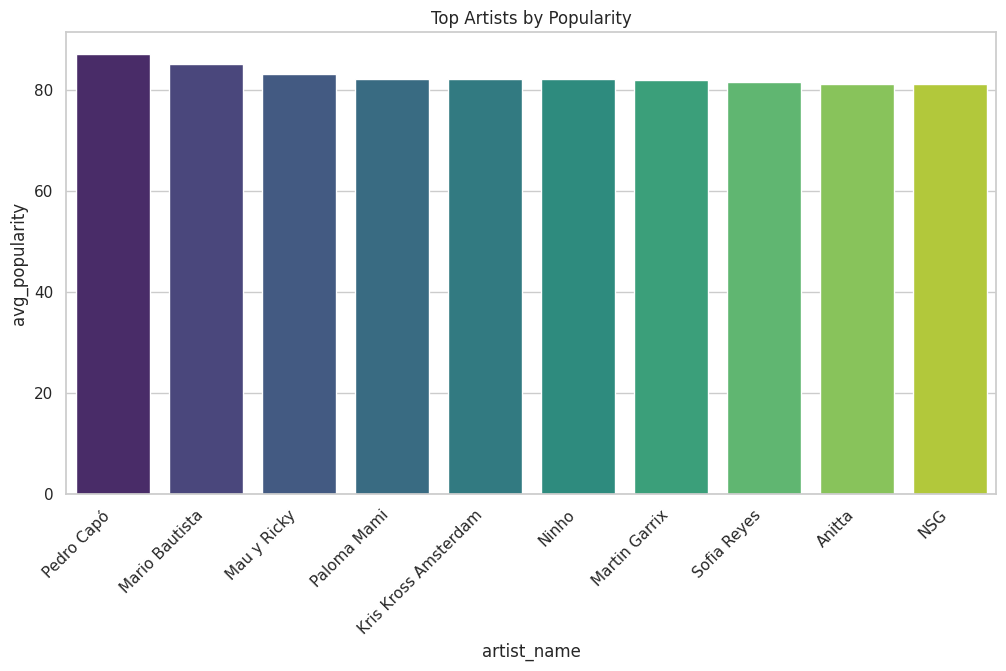

/tmp/ipython-input-340764407.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




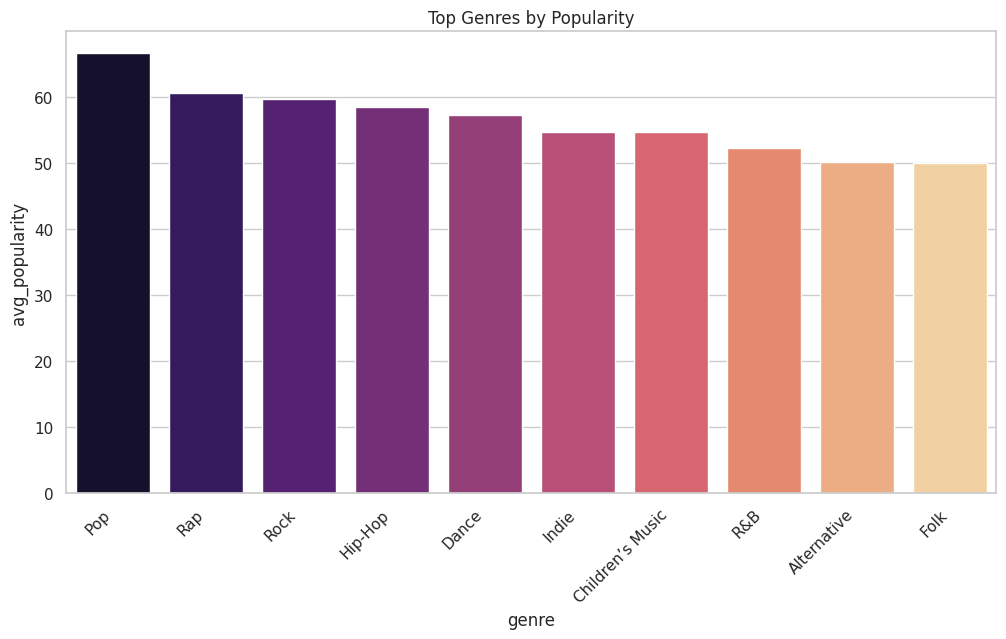

<Figure size 1200x600 with 0 Axes>

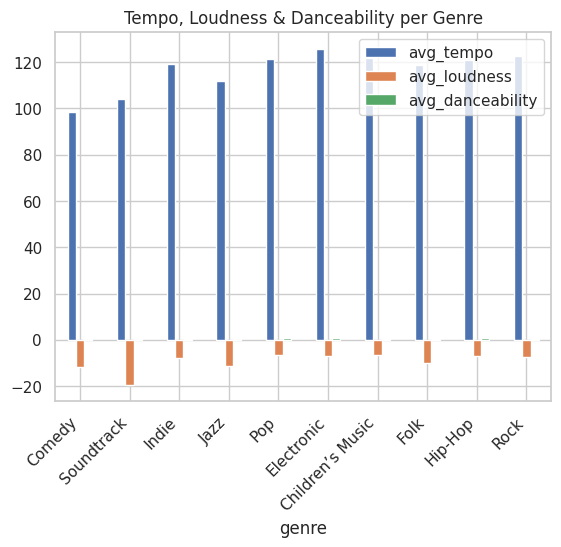

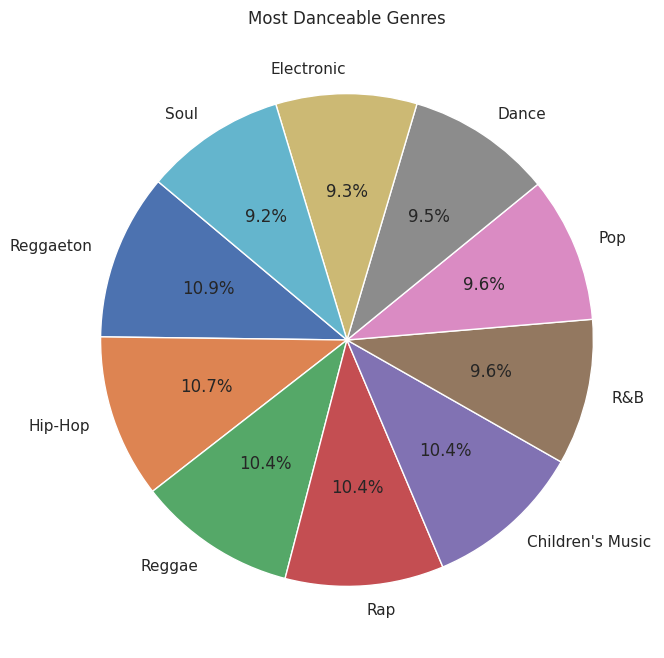

/tmp/ipython-input-340764407.py:51: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




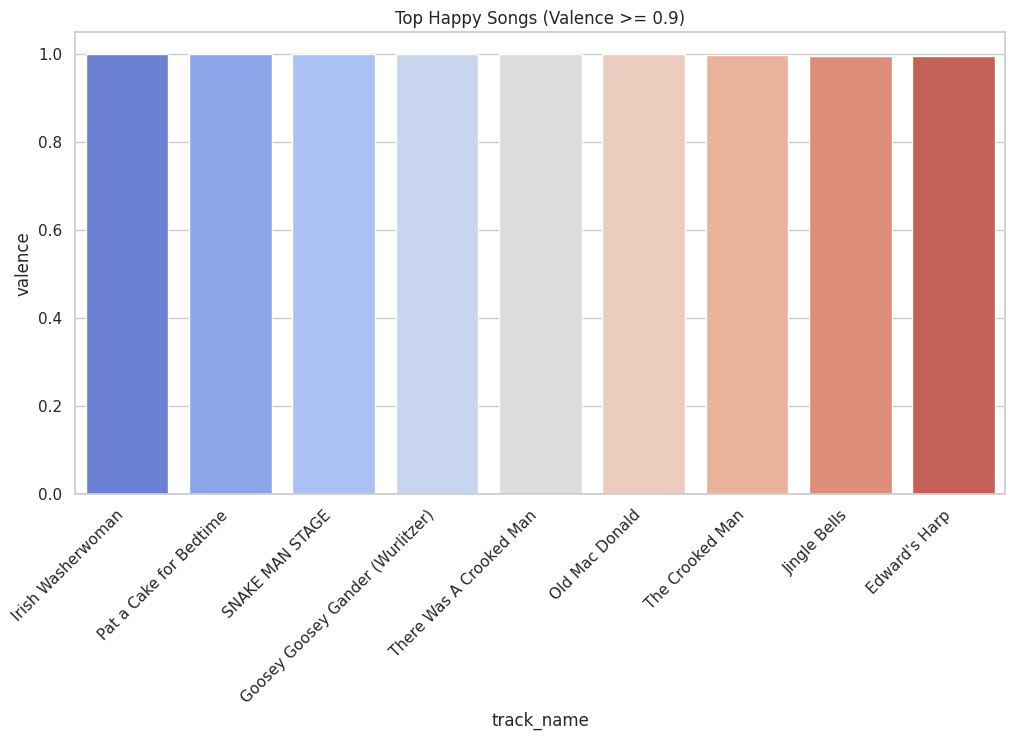

/tmp/ipython-input-340764407.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




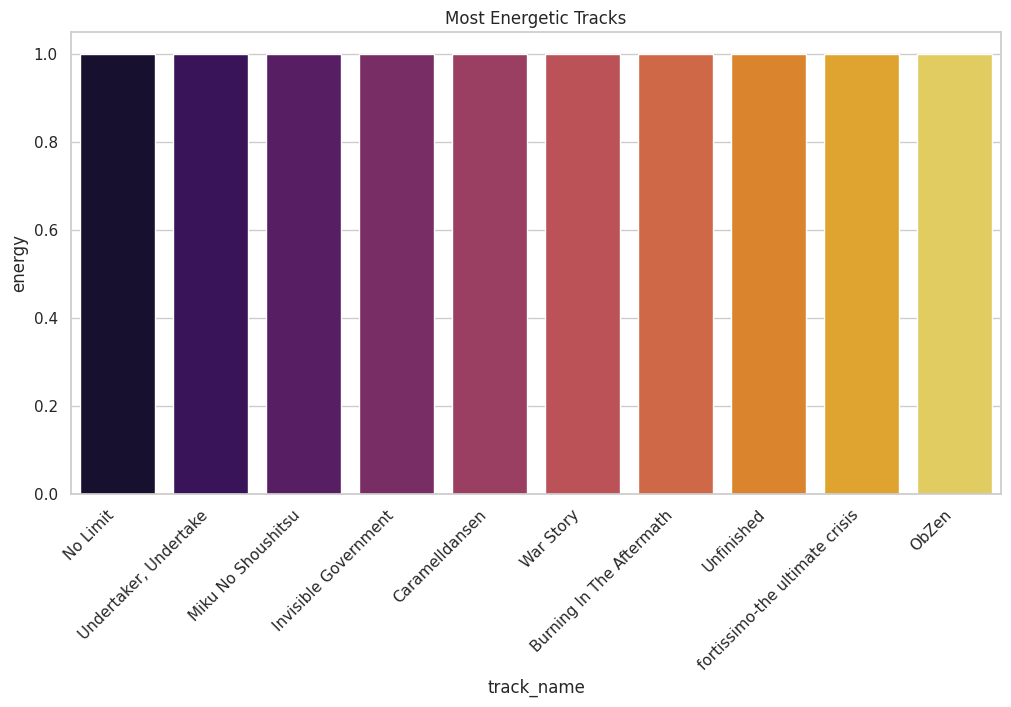

<Figure size 1200x600 with 0 Axes>

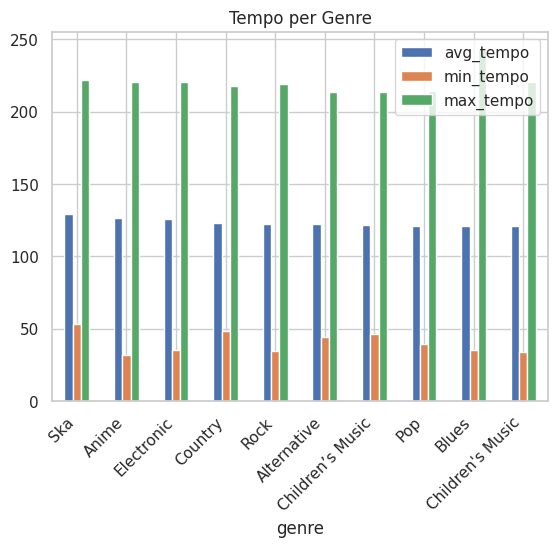

/tmp/ipython-input-340764407.py:69: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




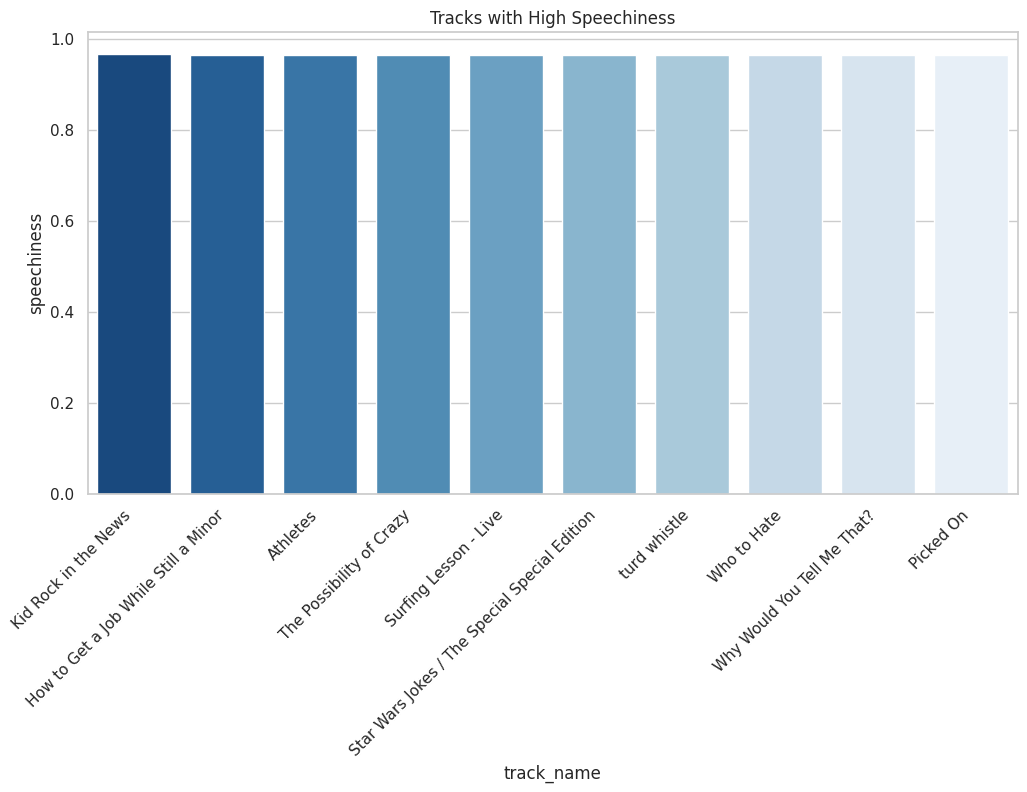

/tmp/ipython-input-340764407.py:75: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




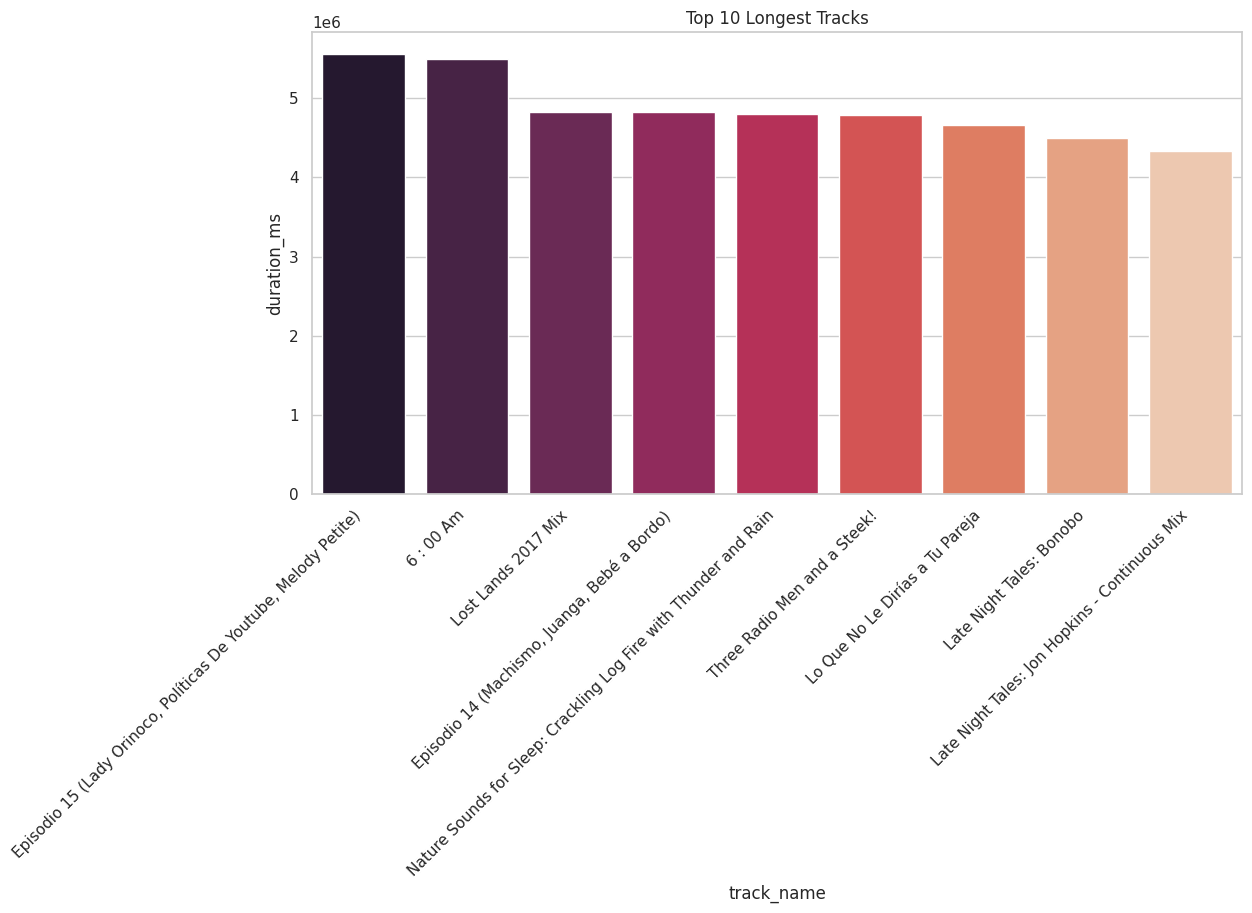

/tmp/ipython-input-340764407.py:81: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




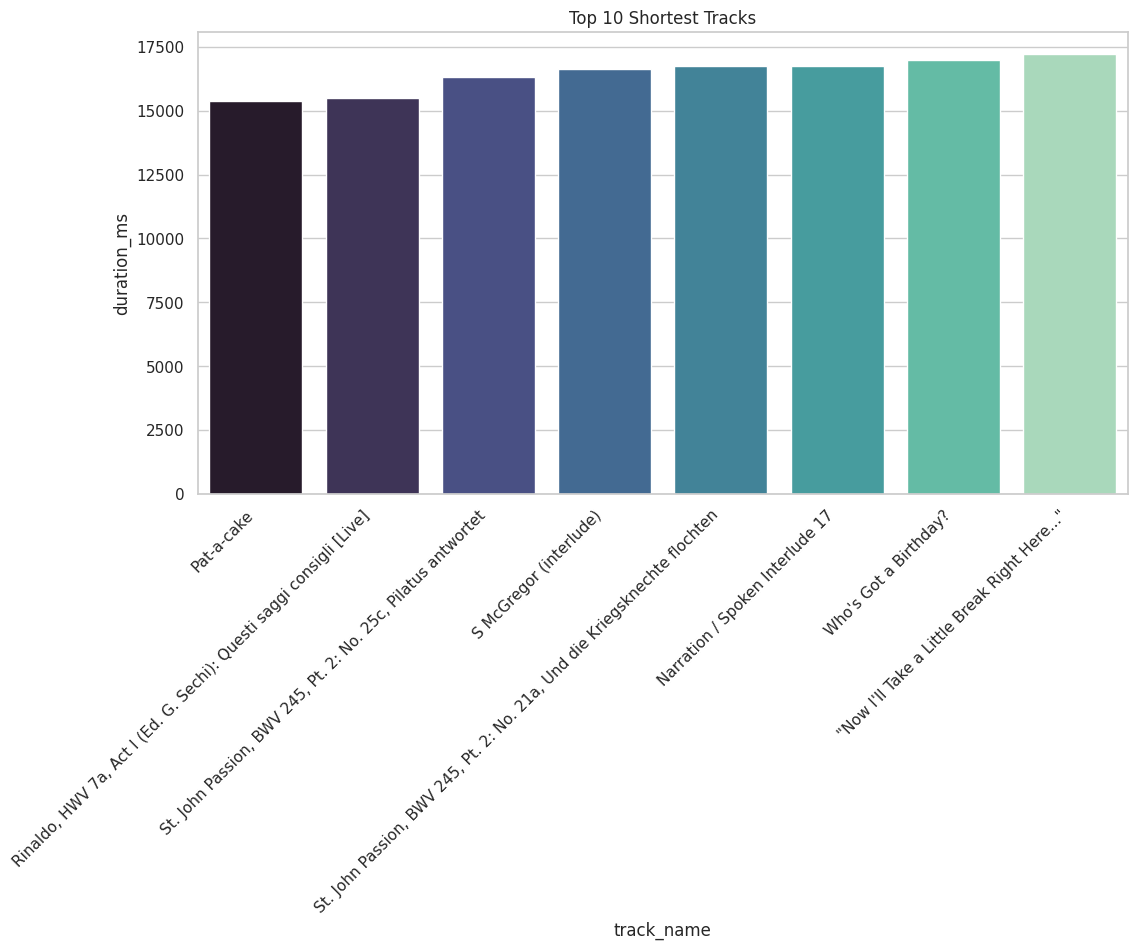

/tmp/ipython-input-340764407.py:87: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




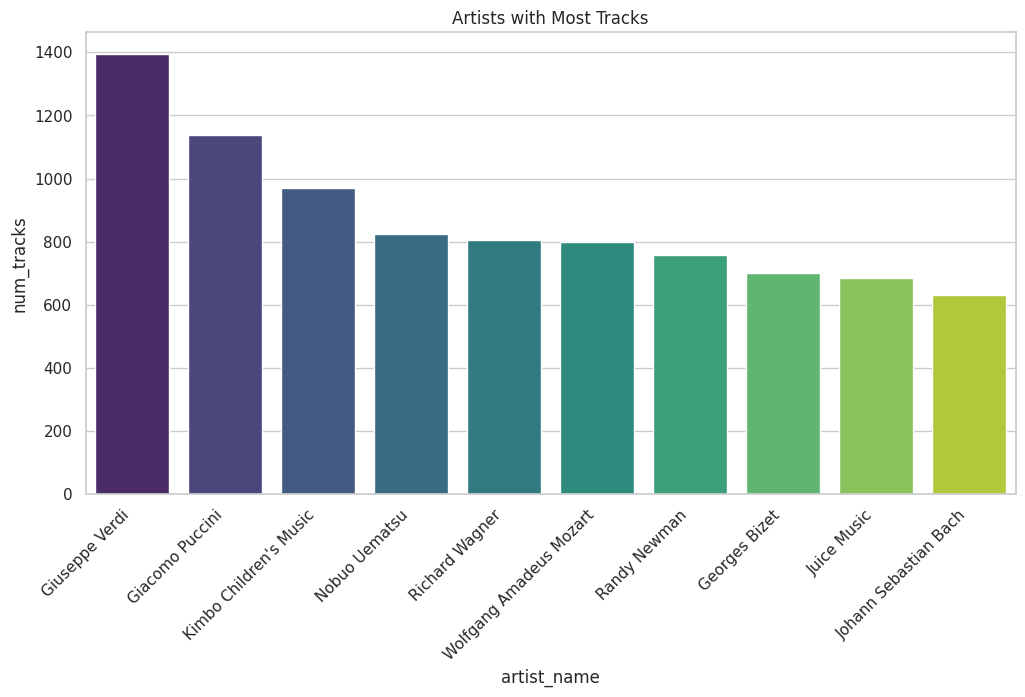

/tmp/ipython-input-340764407.py:93: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




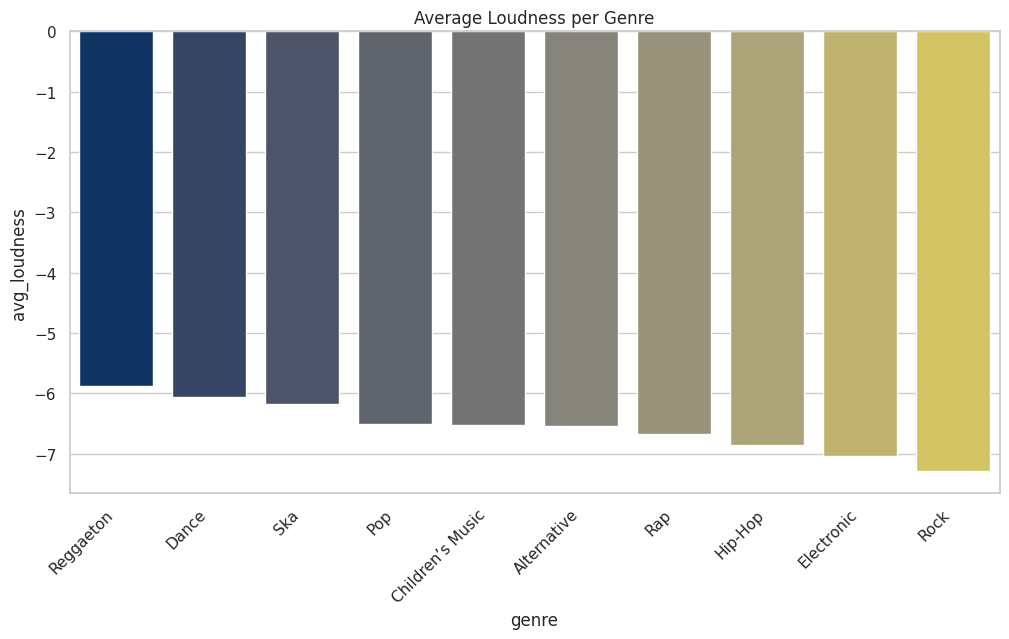

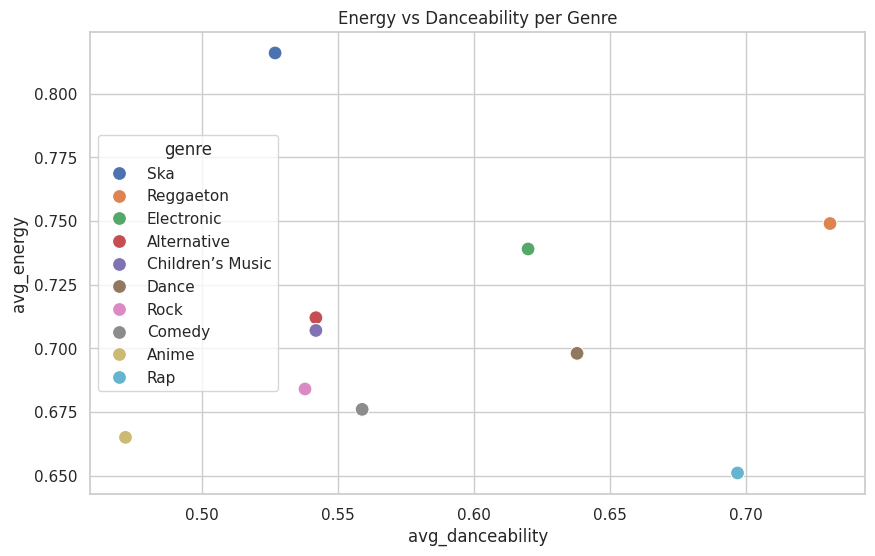

/tmp/ipython-input-340764407.py:104: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




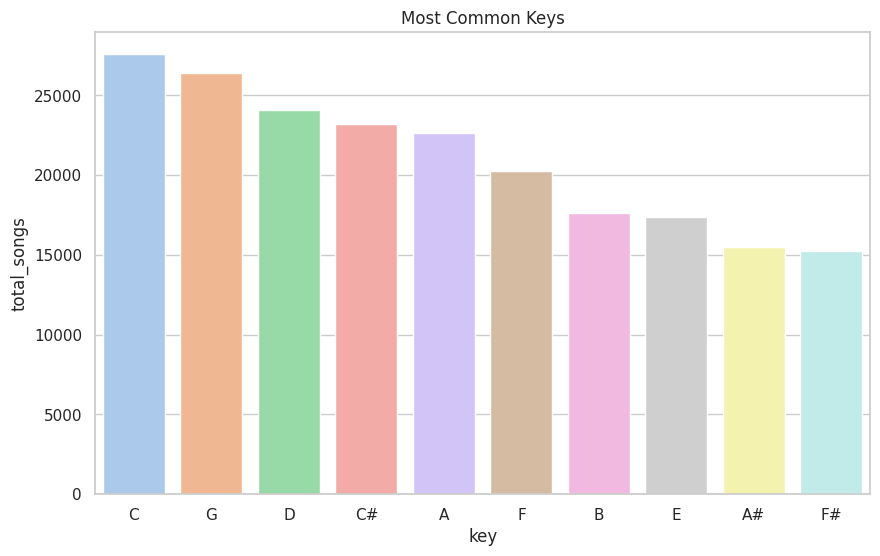

/tmp/ipython-input-340764407.py:109: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




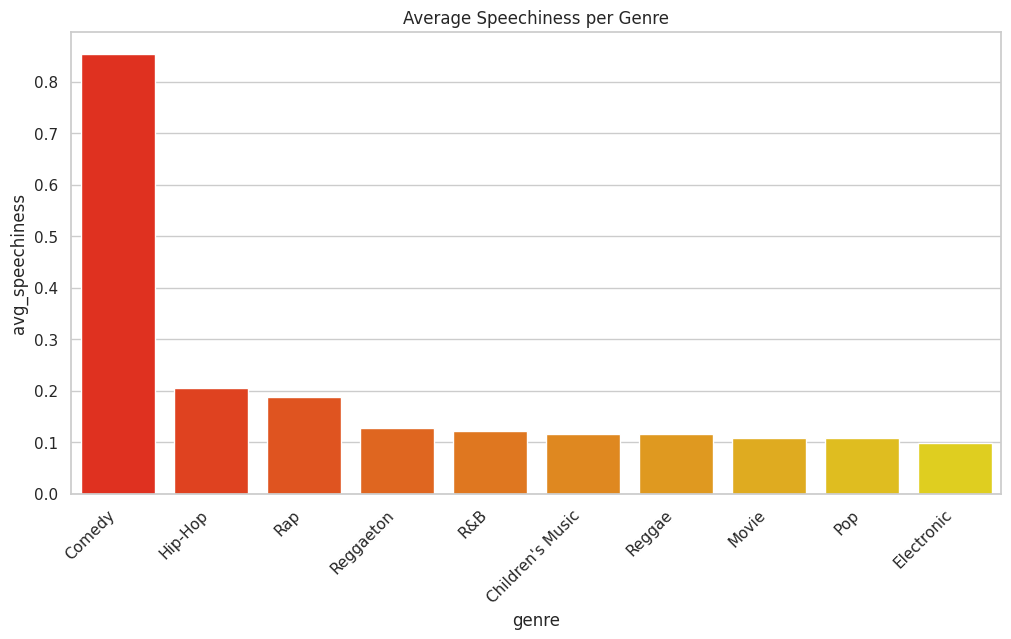

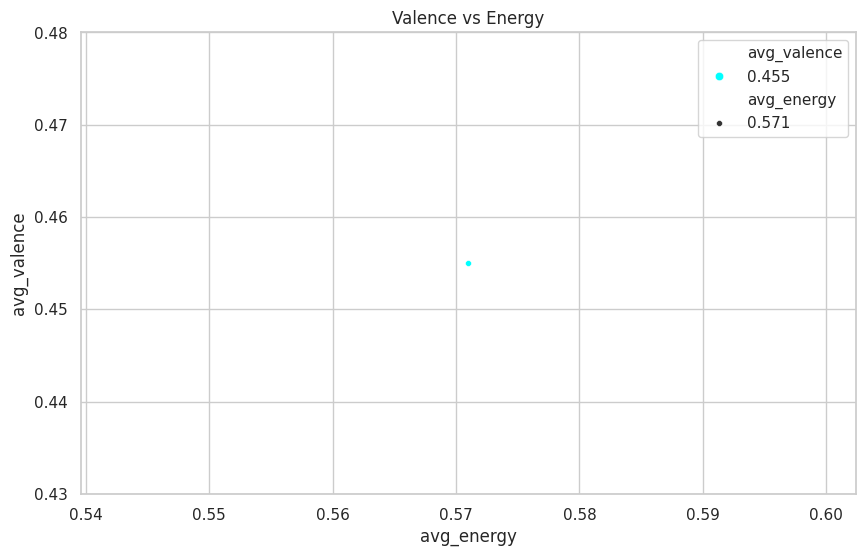

/tmp/ipython-input-340764407.py:120: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




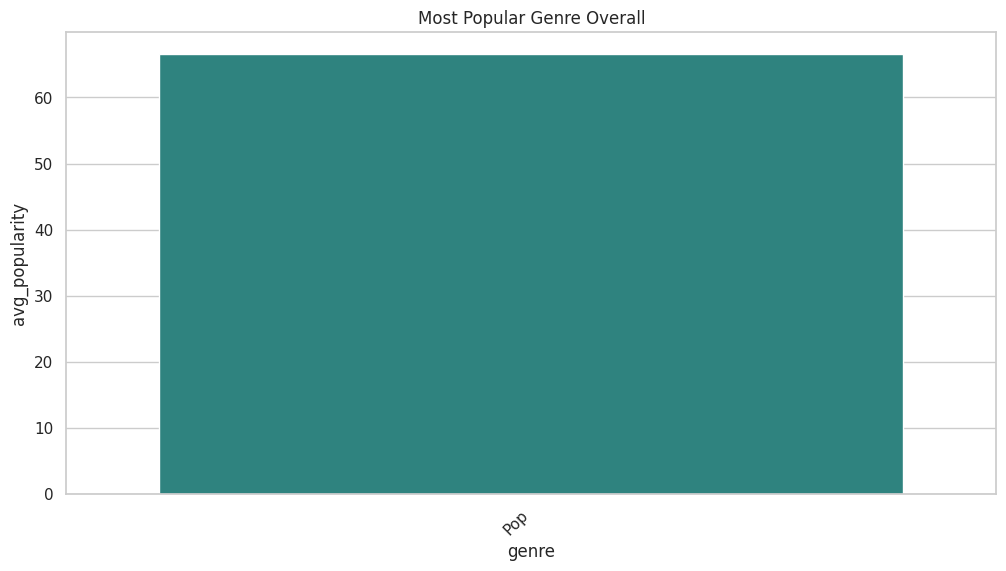

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


top_artists_pd = pd.read_csv("/content/top_artists.csv")
top_genres_pd = pd.read_csv("/content/top_genres.csv")
genre_features_pd = pd.read_csv("/content/genre_features.csv")
danceable_genres_pd = pd.read_csv("/content/danceable_genres.csv")
happy_tracks_pd = pd.read_csv("/content/happy_tracks.csv")
extreme_energy_pd = pd.read_csv("/content/extreme_energy.csv")
tempo_genre_pd = pd.read_csv("/content/tempo_genre.csv")
high_speechiness_pd = pd.read_csv("/content/high_speechiness.csv")
longest_tracks_pd = pd.read_csv("/content/longest_tracks.csv")
shortest_tracks_pd = pd.read_csv("/content/shortest_tracks.csv")
top_artists_count_pd = pd.read_csv("/content/top_artists_count.csv")
avg_loudness_genre_pd = pd.read_csv("/content/avg_loudness_genre.csv")
energy_dance_pd = pd.read_csv("/content/energy_dance.csv")
top_keys_pd = pd.read_csv("/content/top_keys.csv")
speechiness_genre_pd = pd.read_csv("/content/speechiness_genre.csv")
valence_energy_pd = pd.read_csv("/content/valence_energy.csv")
most_popular_genre_pd = pd.read_csv("/content/most_popular_genre.csv")


plt.figure(figsize=(12,6))
sns.barplot(data=top_artists_pd, x="artist_name", y="avg_popularity", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Top Artists by Popularity")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=top_genres_pd, x="genre", y="avg_popularity", palette="magma")
plt.xticks(rotation=45, ha='right')
plt.title("Top Genres by Popularity")
plt.show()

plt.figure(figsize=(12,6))
genre_features_pd.plot(x='genre', y=['avg_tempo','avg_loudness','avg_danceability'], kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title("Tempo, Loudness & Danceability per Genre")
plt.show()

plt.figure(figsize=(8,8))
plt.pie(danceable_genres_pd['avg_danceability'], labels=danceable_genres_pd['genre'], autopct='%1.1f%%', startangle=140)
plt.title("Most Danceable Genres")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=happy_tracks_pd, x="track_name", y="valence", palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.title("Top Happy Songs (Valence >= 0.9)")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=extreme_energy_pd, x="track_name", y="energy", palette="inferno")
plt.xticks(rotation=45, ha='right')
plt.title("Most Energetic Tracks")
plt.show()

plt.figure(figsize=(12,6))
tempo_genre_pd.plot(x='genre', y=['avg_tempo','min_tempo','max_tempo'], kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title("Tempo per Genre")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=high_speechiness_pd, x="track_name", y="speechiness", palette="Blues_r")
plt.xticks(rotation=45, ha='right')
plt.title("Tracks with High Speechiness")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=longest_tracks_pd, x="track_name", y="duration_ms", palette="rocket")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Longest Tracks")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=shortest_tracks_pd, x="track_name", y="duration_ms", palette="mako")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Shortest Tracks")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=top_artists_count_pd, x="artist_name", y="num_tracks", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Artists with Most Tracks")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=avg_loudness_genre_pd, x="genre", y="avg_loudness", palette="cividis")
plt.xticks(rotation=45, ha='right')
plt.title("Average Loudness per Genre")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=energy_dance_pd, x="avg_danceability", y="avg_energy", hue="genre", s=100)
plt.title("Energy vs Danceability per Genre")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=top_keys_pd, x="key", y="total_songs", palette="pastel")
plt.title("Most Common Keys")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=speechiness_genre_pd, x="genre", y="avg_speechiness", palette="autumn")
plt.xticks(rotation=45, ha='right')
plt.title("Average Speechiness per Genre")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=valence_energy_pd, x="avg_energy", y="avg_valence", size="avg_energy", hue="avg_valence", palette="cool")
plt.title("Valence vs Energy")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=most_popular_genre_pd, x="genre", y="avg_popularity", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Most Popular Genre Overall")
plt.show()


In [ ]:

import pandas as pd
import plotly.express as px


top_artists_pd = pd.read_csv("/content/top_artists.csv")
top_genres_pd = pd.read_csv("/content/top_genres.csv")
genre_features_pd = pd.read_csv("/content/genre_features.csv")
danceable_genres_pd = pd.read_csv("/content/danceable_genres.csv")
happy_tracks_pd = pd.read_csv("/content/happy_tracks.csv")
extreme_energy_pd = pd.read_csv("/content/extreme_energy.csv")
tempo_genre_pd = pd.read_csv("/content/tempo_genre.csv")
high_speechiness_pd = pd.read_csv("/content/high_speechiness.csv")
longest_tracks_pd = pd.read_csv("/content/longest_tracks.csv")
shortest_tracks_pd = pd.read_csv("/content/shortest_tracks.csv")
top_artists_count_pd = pd.read_csv("/content/top_artists_count.csv")
avg_loudness_genre_pd = pd.read_csv("/content/avg_loudness_genre.csv")
energy_dance_pd = pd.read_csv("/content/energy_dance.csv")
top_keys_pd = pd.read_csv("/content/top_keys.csv")
speechiness_genre_pd = pd.read_csv("/content/speechiness_genre.csv")
valence_energy_pd = pd.read_csv("/content/valence_energy.csv")
most_popular_genre_pd = pd.read_csv("/content/most_popular_genre.csv")



px.bar(top_artists_pd, x="artist_name", y="avg_popularity",
       color="total_songs", title="Top Artists by Popularity").show()

px.bar(top_genres_pd, x="genre", y="avg_popularity",
       color="total_songs", title="Top Genres").show()

px.bar(genre_features_pd, x="genre",
       y=["avg_tempo","avg_loudness","avg_danceability"],
       barmode="group", title="Tempo, Loudness & Danceability per Genre").show()

px.pie(danceable_genres_pd, names="genre", values="avg_danceability",
       title="Most Danceable Genres").show()

px.bar(happy_tracks_pd, x="track_name", y="valence", color="artist_name",
       title="Top Happy Songs (Valence >= 0.9)").show()

px.bar(extreme_energy_pd, x="track_name", y="energy", color="artist_name",
       title="Most Energetic Tracks").show()

px.bar(tempo_genre_pd, x="genre",
       y=["avg_tempo","min_tempo","max_tempo"],
       barmode="group", title="Tempo per Genre").show()

px.bar(high_speechiness_pd, x="track_name", y="speechiness", color="artist_name",
       title="Tracks with High Speechiness").show()

px.bar(longest_tracks_pd, x="track_name", y="duration_ms", color="artist_name",
       title="Top 10 Longest Tracks").show()

px.bar(shortest_tracks_pd, x="track_name", y="duration_ms", color="artist_name",
       title="Top 10 Shortest Tracks").show()

px.bar(top_artists_count_pd, x="artist_name", y="num_tracks",
       title="Artists with Most Tracks").show()

px.bar(avg_loudness_genre_pd, x="genre", y="avg_loudness",
       title="Average Loudness per Genre").show()

px.scatter(energy_dance_pd, x="avg_danceability", y="avg_energy",
           color="genre", size="avg_energy", title="Energy vs Danceability per Genre").show()

px.bar(top_keys_pd, x="key", y="total_songs", title="Most Common Keys").show()

px.bar(speechiness_genre_pd, x="genre", y="avg_speechiness",
       title="Average Speechiness per Genre").show()

px.scatter(valence_energy_pd, x="avg_energy", y="avg_valence",
           size="avg_energy", color="avg_valence", title="Valence vs Energy").show()

px.bar(most_popular_genre_pd, x="genre", y="avg_popularity",
       title="Most Popular Genre Overall").show()
